# Guide

* Check the entire notebook before you get started, this gives you an idea of what lies ahead.
* Note that, as always, the notebook contains a condensed version of the theory We recommend you read the theory part before the LC session.


## ILOs

After completing this lab you should be able to

* develop neural sequence labellers in PyTorch
* estimate parameters via MLE
* predict tag sequences for novel data
* evaluate tagging performance

## General Notes

* In this notebook you are expected to use $\LaTeX$. 
* Use python3.
* Use Torch. 
* This tutorial runs reasonably quickly on CPU. To have GPU support run this notebook on Google Colab (you will find more instructions later).

We will use a set of standard libraries that are often used in machine learning projects. If you are running this notebook on Google Colab, all libraries should be pre-installed. If you are running this notebook locally you will need to install some additional packages, ask your TA for help if you have problems setting up.

If you need a short introduction to PyTorch [check this tutorial](https://github.com/probabll/ntmi-tutorials/blob/main/PyTorch.ipynb).


## Table of Contents

* [Data](#data)
    * Vocabulary 
    * Corpus and Data Loader
* [Text encoders](#encoders)
    * Word embeddings
    * Concatenation
    * Average pooling
    * RNN encoder
    * Bidirectional RNN encoder
* [Neural Tagger](#tagger)
    * Independent C-way classification
    * Markov tagger
    * Autoregressive tagger
* [Evaluation](#eval)

## Table of Graded Exercises

**Important.** The grader may re-run your notebook to investigate its correctness, but you do upload your notebook with the cells already run and make sure that all your answers are visible without the need to re-run the notebook. 

The weight of the exercise is indicated below.

* [POS tagging data](#freq) (20%)
* [Model size](#size) (20%)
* [Comparison](#comparison) (60%)

## Setting up

In [1]:
import random
import numpy as np
np.random.seed(42)
random.seed(42)

In [2]:
!pip install nltk
!pip install tabulate

# <a name="data" /> Data

In this tutorial we will develop models for sequence labelling. So our data for this tutorial will be collections of sentences, or *corpora*, annotated with token-level tags (e.g., part-of-speech tags or named-entity tags, etc). See [Section 8.2 and 8.3 of the textbook](https://web.stanford.edu/~jurafsky/slp3/8.pdf) to learn more about the data type. 

We will use corpora available in NLTK.

In [3]:
import nltk
nltk.download('treebank')
nltk.download('brown')
nltk.download('punkt')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\timpi\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\timpi\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\timpi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\timpi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\universal_tagset.zip.


True

In [4]:
from nltk.corpus import treebank, brown

# The treebank is small enough for experiments on CPU
# even though it is small, it's an okay size for POS tagging

corpus = treebank

The method `tagged_sents` will give us a view of tokenized sentences with their token lag tag annotation:

In [5]:
example = corpus.tagged_sents(tagset='universal')[0]
example

[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET'),
 ('board', 'NOUN'),
 ('as', 'ADP'),
 ('a', 'DET'),
 ('nonexecutive', 'ADJ'),
 ('director', 'NOUN'),
 ('Nov.', 'NOUN'),
 ('29', 'NUM'),
 ('.', '.')]

In [6]:
from tabulate import tabulate

def tostring(seq_pair, vertical=True, headers=['Word', 'Tag']):
    """
    A sequence of pairs, each pair is a token and a tag. Use vertical=True for tabulate.
    Return a string representing the sequence of pairs.
    """
    if vertical:
        return tabulate(list(seq_pair), headers=headers)
    else:
        return ' '.join(f'{w}/{t}' for w, t in seq_pair)

def tostring2(tok_seq, tag_seq, vertical=True, headers=['Word', 'Tag']):
    """
    A sequence of pairs, each pair is a token and a tag. Use vertical=True for tabulate.
    Return a string representing the sequence of pairs.
    """
    return tostring(zip(tok_seq, tag_seq), vertical=vertical, headers=headers)

In [7]:
print(tostring(example, vertical=False))

Pierre/NOUN Vinken/NOUN ,/. 61/NUM years/NOUN old/ADJ ,/. will/VERB join/VERB the/DET board/NOUN as/ADP a/DET nonexecutive/ADJ director/NOUN Nov./NOUN 29/NUM ./.


In [8]:
print(tostring(example, vertical=True))

Word          Tag
------------  -----
Pierre        NOUN
Vinken        NOUN
,             .
61            NUM
years         NOUN
old           ADJ
,             .
will          VERB
join          VERB
the           DET
board         NOUN
as            ADP
a             DET
nonexecutive  ADJ
director      NOUN
Nov.          NOUN
29            NUM
.             .


In [9]:
def split_nltk_corpus(corpus, max_length=30, num_heldout=100, rng=np.random.RandomState(42)):
    """
    Shuffle and split a corpus.
    corpus: a corpus of tagged sequences, each sequence is a pair, each pair is a token and a tag.
    max_length: discard sentences longer than this

    Return: 
        (training word sequences, training tag sequences), 
        (dev word sequences, dev tag sequences), 
        (test word sequences, test tag sequences),         
    """
    tagged_sentences = corpus.tagged_sents(tagset='universal')
    # do not change the seed in here    
    order = rng.permutation(np.arange(len(tagged_sentences)))    
    word_sequences = [[w.lower() for w, t in tagged_sentences[i]] for i in order if len(tagged_sentences[i]) <= max_length]    
    tag_sequences = [[t for w, t in tagged_sentences[i]] for i in order if len(tagged_sentences[i]) <= max_length]    
    return (word_sequences[2*num_heldout:], tag_sequences[2*num_heldout:]), (word_sequences[num_heldout:2*num_heldout], tag_sequences[num_heldout:2*num_heldout]), (word_sequences[:num_heldout], tag_sequences[:num_heldout])

For `brown` this will take about 1 minute. For `treebank` this will take about 10 seconds.

In [10]:
%%time
(training_x, training_y), (dev_x, dev_y), (test_x, test_y) = split_nltk_corpus(corpus, num_heldout=100 if corpus is treebank else 1000)
print(f"Number of sentences: training={len(training_x)} dev={len(dev_x)} test={len(test_x)}")

Number of sentences: training=2486 dev=100 test=100
CPU times: total: 4.36 s
Wall time: 5.18 s


In [11]:
print("# A few training sentences\n\n")
for n in range(3):    
    print(tostring2(training_x[n], training_y[n]))
    print()

# A few training sentences


Word          Tag
------------  -----
they          PRON
know          VERB
0             X
he            PRON
is            VERB
generally     ADV
opposed       VERB
to            PRT
cop-killer    ADJ
bullets       NOUN
,             .
but           CONJ
that          ADP
he            PRON
had           VERB
some          DET
reservations  NOUN
about         ADP
the           DET
language      NOUN
in            ADP
the           DET
legislation   NOUN
.             .
''            .

Word            Tag
--------------  -----
california      NOUN
's              PRT
education       NOUN
department      NOUN
suspects        VERB
adult           NOUN
responsibility  NOUN
for             ADP
erasures        NOUN
at              ADP
40              NUM
schools         NOUN
that            DET
*t*-85          X
changed         VERB
wrong           ADJ
answers         NOUN
to              PRT
right           ADJ
ones            NOUN
on              ADP
a      

## <a name="freq"/> Graded exercises - POS tagging data

* Plot the marginal frequency of the tags in the dataset
* List the most frequent nouns, verbs, adjectives, and adverbs. Use top-10. 
* Find examples of words that show ambiguity of POS.


In [85]:
tagged_sentences = corpus.tagged_sents(tagset='universal')
print(tagged_sentences)

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], ...]


top 10 most frequent nouns, verbs, adjectives and adverbs: 
(the first row is the most frequent)
+-----------+-------+-----------+--------+
|   noun    | verb  | adjective | adverb |
+-----------+-------+-----------+--------+
|     %     |  is   |    new    |  n't   |
|    Mr.    | said  |   other   |  also  |
|  company  |  was  |   more    |  not   |
|   U.S.    |  are  |   last    |  more  |
|   year    |  be   |   many    |  when  |
|  market   |  has  |   such    |  only  |
|    New    | have  | Japanese  |  even  |
|  trading  | will  |  recent   |  now   |
|   stock   | says  |   first   |   so   |
| president | would |   next    |   as   |
+-----------+-------+-----------+--------+


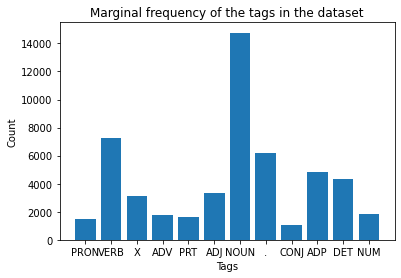


The following word are examples of words that are both tagged atleast once as NOUN  and ADJ
['Philippine', 'composite', 'principal', 'German', 'one-third']

The following word are examples of words that are both tagged atleast once as NOUN  and VERB
['sets', 'challenge', 'back', 'mailing', 'dislike']

The following word are examples of words that are both tagged atleast once as NOUN  and DET
['A', 'All', 'half', 'the', 'The']

The following word are examples of words that are both tagged atleast once as NOUN  and ADP
['down', 'are', 'and', 'In', 'while']

The following word are examples of words that are both tagged atleast once as NOUN  and CONJ
['minus', 'and', 'plus']

The following word are examples of words that are both tagged atleast once as NOUN  and ADV
['down', 'vice', 'high', 'Currently', 'stocks']

The following word are examples of words that are both tagged atleast once as NOUN  and PRT
['down', 'in', 'back']

The following word are examples of words that are both tagged

In [136]:
from collections import Counter, defaultdict


tagged_sentences = corpus.tagged_sents(tagset='universal')
pos_freq = Counter()
word_freq = defaultdict(lambda: defaultdict(int))

for y in training_y+dev_y+test_y:
    pos_freq += Counter(y)
    
for sent in tagged_sentences:
    for w, t in sent:
        word_freq[t][w] += 1

[i[0] for i in e]
top10_noun  = [i[0] for i in sorted(word_freq["NOUN"].items(), key=lambda x:x[1], reverse=True)[:10]]
top10_verbs  = [i[0] for i in sorted(word_freq["VERB"].items(), key=lambda x:x[1], reverse=True)[:10]]
top10_adj = [i[0] for i in sorted(word_freq["ADJ"].items(), key=lambda x:x[1], reverse=True)[:10]]
top10_adv  = [i[0] for i in sorted(word_freq["ADV"].items(), key=lambda x:x[1], reverse=True)[:10]]

print("top 10 most frequent nouns, verbs, adjectives and adverbs: \n(the first row is the most frequent)")
print(tabulate(np.transpose([top10_noun, top10_verbs, top10_adj, top10_adv]), headers=["noun", "verb", "adjective","adverb"], tablefmt="pretty"))


plt.bar(pos_freq.keys(), pos_freq.values())
plt.xlabel("Tags")
plt.ylabel("Count")
plt.title("Marginal frequency of the tags in the dataset")
plt.show()

# words with ambiguity:
all_nouns = set(word_freq["NOUN"])

for tag, tag_dict in word_freq.items():
    if tag == "NOUN" or tag == "." or tag == "NUM" or tag == "X":
        continue
    print(f"\nThe following word are examples of words that are both tagged atleast once as NOUN  and {tag}")
    print(list(all_nouns.intersection(set(tag_dict.keys())))[:5])
    
print("\nThe lists above show examples of words that show ambiguity of POS, that is, common words that have multiple meanings and therefore multiple POS tags.")

## Vocabulary

As always when dealing with NLP models, we need an object to maintain our vocabulary of known tokens. This time we will rely on word-tokenization rather than BPE tokenization. Fortunately, NLK corpora are already tokenized.

Our vocabulary class will maintain the set of known tokens, and a dictionary to convert tokens to codes and codes back to tokens. The class will also take care of some special symbols (e.g., BOS, EOS, UNK, PAD). 

Finally, if later on you test your model on sentences that are not word tokenized, you can use `nlt.tokenize.word_tokenize` or any other tokenizer you like (as long as the level of tokenization is similar to the one you used for training your model.

In [13]:
from nltk.tokenize import word_tokenize

This is how you can tokenize English sentences (but remember that we don't need to redo this for the training/dev/test data from NLKT):

In [14]:
word_tokenize("This is a sentence, and this is another.")

['This', 'is', 'a', 'sentence', ',', 'and', 'this', 'is', 'another', '.']

We will adapt one of the classes we developed in previous tutorials, and this class will be used for maintaining both the vocabulary of known tokens and the set of known tags.

In [15]:
import numpy as np
from itertools import chain
from collections import Counter, OrderedDict

class Vocab:

    def __init__(self, corpus: list, min_freq=1):        
        """
        corpus: list of documents, each document is a list of tokens, each token is a string
        min_freq: words that occur less than this value are discarded
        """
        # Make the vocabulary of known words

        # Count word occurrences
        counter = Counter(chain(*corpus))
        # sort them by frequency
        sorted_by_freq_tuples = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)
        
        # Special tokens
        self.pad_token = "-PAD-"        
        self.bos_token = "-BOS-"
        self.eos_token = "-EOS-"
        self.unk_token = "-UNK-"
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2
        self.unk_id = 3

        self.known_symbols = [self.pad_token, self.bos_token, self.eos_token, self.unk_token]
        self.counts = [0, 0]
        
        # Vocabulary
        self.word2id = OrderedDict()                
        self.word2id[self.pad_token] = self.pad_id        
        self.word2id[self.bos_token] = self.bos_id
        self.word2id[self.eos_token] = self.eos_id
        self.word2id[self.unk_token] = self.unk_id
        self.min_freq = min_freq
        for w, n in sorted_by_freq_tuples: 
            if n >= min_freq: # discard infrequent words
                self.word2id[w] = len(self.known_symbols)
                self.known_symbols.append(w)
                self.counts.append(n)
        
        # store the counts for later
        self.counts = np.array(self.counts)

    def __len__(self):
        return len(self.known_symbols)

    def __getitem__(self, word): # return the id (int) of a word (str)
        return self.word2id.get(word, self.unk_id)

    def encode(self, doc: list, add_bos=False, add_eos=False, pad_right=0):
        """
        Transform a document into a sequence of integer token identifiers.
        doc: list of tokens, each token is a string
        add_bos: whether to add the BOS token
        add_eos: whether to add the EOS token
        pad_right: number of suffix padding tokens 
        
        Return: a list of codes (possibly with BOS and EOS added as well as padding)
        """
        return [self.word2id.get(w, self.unk_id) for w in chain([self.bos_token] * int(add_bos), doc, [self.eos_token] * int(add_eos), [self.pad_token] * pad_right)]

    def batch_encode(self, docs: list, add_bos=False, add_eos=False):
        """
        Transform a batch of documents into a numpy array of integer token identifiers.
        This will pad the shorter documents to the length of the longest document.
        docs: a list of documents
        add_bos: whether to add the BOS token
        add_eos: whether to add the EOS token
        pad_right: number of suffix padding tokens

        Return: numpy array with shape [len(docs), longest_doc + add_bos + add_eos]
        """
        max_len = max(len(doc) for doc in docs)
        return np.array([self.encode(doc, add_bos=add_bos, add_eos=add_eos, pad_right=max_len-len(doc)) for doc in docs])

    def decode(self, ids, strip_pad=False):
        """
        Transform a np.array document into a list of tokens.
        ids: np.array with shape [num_tokens] 
        strip_pad: whether PAD tokens should be deleted from the output

        Return: list of strings with size [num_tokens - num_padding]
        """
        if strip_pad:
            return [self.known_symbols[id] for id in ids if id != self.pad_id]
        else:
            return [self.known_symbols[id] for id in ids]

    def batch_decode(self, docs, strip_pad=False):
        """
        Transform a np.array collection of documents into a collection of lists of tokens.
        ids: np.array with shape [num_docs, max_length] 
        strip_pad: whether PAD tokens should be deleted from the output

        Return: list of documents, each a list of tokens, each token a string
        """
        return [self.decode(doc, strip_pad=strip_pad) for doc in docs]    

Let's see how this works:

In [16]:
# we get a vocabulary for words
word_vocab = Vocab(training_x, min_freq=2)
# and a vocabulary for tags
tag_vocab = Vocab(training_y, min_freq=1)
# you can see their sizes V and C:
len(word_vocab), len(tag_vocab)

(3358, 16)

The `encode` method turns a sequence of (str) symbols into a sequence of (int) codes:

In [17]:
print(tostring2(word_vocab.encode(training_x[0]), tag_vocab.encode(training_y[0]), vertical=True))

  Word    Tag
------  -----
    45     14
   907      5
    13     10
    36     14
    18      5
   600     12
  1078      5
     8     13
  1651      9
  1652      4
     6      6
    41     15
    19      7
    36     14
    66      5
    71      8
  2194      4
    55      7
     5      8
  2195      4
    10      7
     5      8
   487      4
     4      6
    21      6


We can also have `encode` add some special symbols for us (but remember to be consistent, you should always have token sequences and tag sequences that match in length):

In [18]:
print(tostring2(word_vocab.encode(training_x[0], add_eos=True), tag_vocab.encode(training_y[0], add_eos=True)))

  Word    Tag
------  -----
    45     14
   907      5
    13     10
    36     14
    18      5
   600     12
  1078      5
     8     13
  1651      9
  1652      4
     6      6
    41     15
    19      7
    36     14
    66      5
    71      8
  2194      4
    55      7
     5      8
  2195      4
    10      7
     5      8
   487      4
     4      6
    21      6
     2      2


Here for example, we will add BOS, EOS, and we are going to encode and decode:

In [19]:
print(tostring2(word_vocab.decode(word_vocab.encode(training_x[0], add_bos=True, add_eos=True)), tag_vocab.decode(tag_vocab.encode(training_y[0], add_bos=True, add_eos=True))))

Word          Tag
------------  -----
-BOS-         -BOS-
they          PRON
know          VERB
0             X
he            PRON
is            VERB
generally     ADV
opposed       VERB
to            PRT
cop-killer    ADJ
bullets       NOUN
,             .
but           CONJ
that          ADP
he            PRON
had           VERB
some          DET
reservations  NOUN
about         ADP
the           DET
language      NOUN
in            ADP
the           DET
legislation   NOUN
.             .
''            .
-EOS-         -EOS-


We can also encode and decode entire batches of sequences. This will use pad symbols/codes to make the sequences in the same batch have the same length:

In [20]:
word_vocab.batch_encode(training_x[:2], add_bos=False, add_eos=True)

array([[  45,  907,   13,   36,   18,  600, 1078,    8, 1651, 1652,    6,
          41,   19,   36,   66,   71, 2194,   55,    5, 2195,   10,    5,
         487,    4,   21,    2],
       [ 488,   14, 1309,  156, 2196,    3,    3,   16,    3,   31,  449,
         908,   19,    3,  601,  909,  772,    8,  343,  910,   26,    9,
        2197,  344,    4,    2]])

In [21]:
word_vocab.batch_decode(word_vocab.batch_encode(training_x[:2], add_bos=False, add_eos=True), strip_pad=True)

[['they',
  'know',
  '0',
  'he',
  'is',
  'generally',
  'opposed',
  'to',
  'cop-killer',
  'bullets',
  ',',
  'but',
  'that',
  'he',
  'had',
  'some',
  'reservations',
  'about',
  'the',
  'language',
  'in',
  'the',
  'legislation',
  '.',
  "''",
  '-EOS-'],
 ['california',
  "'s",
  'education',
  'department',
  'suspects',
  '-UNK-',
  '-UNK-',
  'for',
  '-UNK-',
  'at',
  '40',
  'schools',
  'that',
  '-UNK-',
  'changed',
  'wrong',
  'answers',
  'to',
  'right',
  'ones',
  'on',
  'a',
  'statewide',
  'test',
  '.',
  '-EOS-']]

## Corpus and Data Loader

We will be developing our models in torch, thus we need to wrap our corpus into a `Dataset` and a `DataLoader`:

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader

class TaggedCorpus(Dataset):
    """
    Use this to give torch access to a corpus of tagged sequences.
    This class will also know the vocab objects for tokens and tags, 
    and it will take care of coding strings into integers consistently.
    """

    def __init__(self, corpus_x, corpus_y, word_vocab: Vocab, tag_vocab: Vocab):
        """
        In PyTorch we better always manipulate numerical codes, rather than text.
        So, our Corpus object will contain a vocab that converts words to codes.

        corpus_x: token sequences
        corpus_y: tag sequences
        word_vocab: vocabulary for token sequences
        tag_vocab: vocabulary for tag sequences
        """
        self.corpus_x = list(corpus_x)
        self.corpus_y = list(corpus_y)
        assert len(self.corpus_x) == len(self.corpus_y), "I need sequence pairs"
        assert all(len(x) == len(y) for x, y in zip(corpus_x, corpus_y)), "A sequence pair should match in number of steps"
        self.word_vocab = word_vocab
        self.tag_vocab = tag_vocab

    def __len__(self):
        """Size of the corpus in number of sequence pairs"""
        return len(self.corpus_x)
    
    def __getitem__(self, idx):
        """Return corpus_x[idx] and corpus_y[idx] converted to codes and with the EOS code in the end"""
        x = self.word_vocab.encode(self.corpus_x[idx], add_bos=False, add_eos=True)
        y = self.tag_vocab.encode(self.corpus_y[idx], add_bos=False, add_eos=True)
        return x, y

    @classmethod
    def pad_to_longest(cls, pairs, pad_id=0):
        """
        Take a list of coded sequences and returns a torch tensor where 
        every sentence has the same length (by means of using PAD tokens)
        """
        longest = max(len(x) for x, y in pairs)
        batch_x = torch.tensor([x + [pad_id] * (longest - len(x)) for x, y in pairs]) 
        batch_y = torch.tensor([y + [pad_id] * (longest - len(y)) for x, y in pairs]) 
        return batch_x, batch_y

Here we join the token sequences and tag sequences from NLTK into `Dataset` objects for training, development and testing. Note that they share the same vocabularies which were constructed using the training set alone.

In [23]:
training = TaggedCorpus(training_x, training_y, word_vocab, tag_vocab)
dev = TaggedCorpus(dev_x, dev_y, word_vocab, tag_vocab)
test = TaggedCorpus(test_x, test_y, word_vocab, tag_vocab)

Here's an example of how we get a `DataLoader` for a corpus, we simply choose the `Dataset` object we want (training/dev/test), the batch size we want, whether we need shuffling (e.g., for training batches in SGD), and how we "glue" data points of different length together (i.e., a function such as `pad_to_longest` which `TaggedCorpus` provides for us).

In [24]:
batcher = DataLoader(training, batch_size=3, shuffle=True, collate_fn=TaggedCorpus.pad_to_longest)
for batch_x, batch_y in batcher:
    print("# This is how the sequence pairs in a batch come out of the data loader\n")

    for x, y in zip(batch_x, batch_y):
        print(tostring2(x, y))
        print()
    
    print("# And we can always decode them for inspection\n")
    # stripping padding makes it easier to read the examples
    for x, y in zip(word_vocab.batch_decode(batch_x, strip_pad=True), tag_vocab.batch_decode(batch_y, strip_pad=True)):
        print(tostring2(x, y))
        print()
    break

# This is how the sequence pairs in a batch come out of the data loader

  Word    Tag
------  -----
     5      8
   528      9
   250      4
   316      7
  3014      4
    14     13
  2869      4
  1053      4
     3      4
   567      4
    11     15
     5      8
   478      4
     3      5
    31      7
  2435      4
   215      4
     4      6
     2      2
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0

  Word    Tag
------  -----
  2514      4
  1475      4
   391      4
   245      4
     6      6
   156      4
     7      7
     3      4
    11     15
  1475      4
   391      4
    72      6
     2      2
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0
     0      0

  Word    Tag
------  -----
 

# <a name="encoders" /> Text encoders

In NLP applications, we often have to *encode* a piece of text. For example, that is the case in text classification as well as in sequence labelling. 

Assume for example, a text classifier that takes a document $x_{1:l} = \langle x_1, \ldots, x_l \rangle$, where each token $x_i \in \mathcal W$ is from a finite vocabulary of $V$ tokens and predicts a distribution over $C$ classes from a set $\mathcal T = \{1, \ldots, C\}$.

## Word embeddings

The very first thing we learnt about text encoding is that we need to map tokens (discrete symbols in a set of size $V$) to points in geometrical space. The embedding layer is a simple architecture for that, 

\begin{align}
    \mathbf e_i &= \mathrm{embed}_D(x_i; \theta_{\text{in}})
\end{align}

It realises a simple lookup operation retrieving from a matrix of $V \times D$ parameters the $D$-dimensional vector that corresponds to the $i$th token of the sequence.

In [25]:
import torch
from torch import nn

In [26]:
def num_parameters(torch_module):
    """A helper to count the number of parameters in a torch module"""
    return sum(np.prod(theta.shape) for theta in torch_module.parameters())

In [27]:
toy_batch = torch.tensor(
    [
     [3, 4, 5, 2],  # assume that every sentence ends in the EOS token, and assume the code for it is 2
     [5, 7, 2, 0]   # assume that the code for the PAD token is 0
    ]
)
toy_batch

tensor([[3, 4, 5, 2],
        [5, 7, 2, 0]])

In [28]:
# this creates the layer with untrained parameters
toy_emb_dim = 8
toy_vocab_size = 10
toy_emb = nn.Embedding(num_embeddings=toy_vocab_size, embedding_dim=toy_emb_dim)
toy_emb

Embedding(10, 8)

In [29]:
assert num_parameters(toy_emb) == toy_vocab_size * toy_emb_dim, "Embedding layers are built upon [V, D] matrices"

In [30]:
# this embeds the tokens in the sequences in the batch
e = toy_emb(toy_batch)
print(e.shape)

torch.Size([2, 4, 8])


In [31]:
assert toy_emb(toy_batch).shape == toy_batch.shape + (toy_emb_dim,)

## Concatenation

We also learnt that we can concatenate embeddings making a representation for short phrases. For example, 

\begin{align}
    \mathbf u_i &= \mathrm{concat}(\mathbf e_{i-1}, \mathbf e_i)
\end{align}

makes a representation for the bigram $\langle x_{i-1}, x_i \rangle$.

This type of encoding mechanism works whenever the phrase we are trying to encode has a fixed length (e.g., always 2 words, or always 3 words). But it does not work for entire documents, that's because documents vary in length, so depending on the document the encoding would have a different dimensionality.

In [32]:
# There are different ways to achieve concatenation 
# [batch_size, max_len, emb_dim]
e = toy_emb(toy_batch)
# Let's get the embeddings of the first two tokens
e0 = e[:,0]
e1 = e[:,1]
e0.shape, e1.shape

(torch.Size([2, 8]), torch.Size([2, 8]))

In [33]:
# and concatenate them

print(torch.cat([e0, e1], -1).shape)

assert torch.cat([e0, e1], -1).shape == (2, 2*toy_emb_dim)

torch.Size([2, 16])


In [34]:
# if you want to concatenate the vectors for all words in the sequence
# you could just reshape the tensor as follows
# [batch_size, max_len * emb_dim]
u = e.reshape((toy_batch.shape[0], -1))
print(u.shape)

assert u.shape == (toy_batch.shape[0], toy_batch.shape[1] * toy_emb_dim), "Did you change the embed_dim?"

torch.Size([2, 32])


## Average pooling 

Whenever we need to combine a variable number of $D$-dimensional vectors into a single $D$-dimensional vector, we can use an elementwise average. This is known as *average pooling*:

\begin{align}
    \mathbf u &= \frac{1}{l} \sum_{i=1}^l \mathbf e_i
\end{align}

This average pooling operation takes a number $l > 0$ of $D$-dimensional inputs and returns a single $D$-dimensional output. While it achieves the task of representing the entire document $x_{1:l}$ it has serious limitations. For example, it discards any information in the order of the document.

In [35]:
# [batch_size, max_len, emb_dim]
e = toy_emb(toy_batch)
# here we replace padding embeddings by 0, so they do not affect the average
# unsqueeze(-1) is needed because e has an extra axis compared to toy_batch
masked_e = torch.where((toy_batch > 0).unsqueeze(-1), e, torch.zeros_like(e))
# we sum the embeddings of the valid positions (those that are not PADs)
# and divide by sequence length (as we always have an EOS token, length is never 0)
avg = torch.sum(masked_e, 1) / torch.sum((toy_batch > 0).float(), -1, keepdims=True)
print(avg.shape)

# Note how the 'step' or 'time' dimension is gone
assert avg.shape == (toy_batch.shape[0], toy_emb_dim)

torch.Size([2, 8])


## RNN encoder

The RNN encoder is very similar to the RNN generator that we learnt that we use for language modelling. The difference is very subtle, but also very important.

Relative to the position we want to generate, the RNN generator can only see the past. That is because we are generating from left-to-right, and only the past is available for that. Don't be confused, during training of the language model you already know the entire sentence, but still you cannot use information beyond the past, otherwise it would be impossible to use the model after training, when you don't know what's ahead.

To recap, suppose we want to generate the sequence $x_{1:l}$ and that we have embedded its words already (i.e., $\mathbf e_j = \mathrm{embed}_D(x_j; \theta_{\text{in}})$), the **RNN generator** uses an RNN cell with inputs about the past:
\begin{align}
\mathbf u_i &= \mathrm{rnnstep}_K(\mathbf u_{i-1}, \mathbf e_{i-1}; \theta_{\text{hid}})
\end{align}
the output $\mathbf u_i$ is $K$-dimensional and it depends on the previous state of cell $\mathbf u_{i-1}$ and the previous word $\mathbf e_{i-1}$, through the previous state it also depends on every word before that, and in order. For the 1st state we assume $\mathbf u_0 = \mathbf 0$.

The **RNN encoder** is not used in situations where we are interested in generating $x_{1:l}$, rather, it is used in situations where we can count on the whole of $x_{1:l}$ being available to us (for example, where we are classifying $x_{1:l}$ into a sentiment label, or where we are labelling the steps of $x_{1:l}$ using a certain tagset). Because of that, the RNN encoder *can* (and *should*) use an RNN cell that has access to information about the present (not only the past):
\begin{align}
\mathbf u_i &= \mathrm{rnnstep}_K(\mathbf u_{i-1}, \underline{\mathbf e_{i}}; \theta_{\text{enc}}) ~.
\end{align}
See how this RNN cell is not seeing only the past, it can see the current position too (which we underline for your attention). That is, the state $\mathbf u_i$ knows about the past (through $\mathbf u_{i-1}$) and it also knows about the present (through $\mathbf e_i$).

The RNN encoder can be denoted compactly as 
\begin{align}
\mathbf u_{1:l} &= \mathrm{rnnenc}_K(\mathbf e_{1:l}; \theta_{\text{enc}})
\end{align}
it takes a sequence of vectors as input and returns a sequence of $K$-dimensional vectors as output. The last vector  $\mathbf u_l$ in the output sequence has information about the entire document $x_{1:l}$ in order.


See the figure for a comparison between the RNN generator and the RNN encoder:
<img src="https://raw.githubusercontent.com/probabll/ntmi-tutorials/main/img/rnn.jpeg" alt="drawing" width="500"/>


### LSTM

In this tutorial we will use a modern architecture for the recurrent cell called [*Long Short-Term Memory*](https://arxiv.org/pdf/1503.04069.pdf) (LSTM for short). [It's already implemented for us in torch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).

You do not need to study the LSTM paper, what you will need to know will be explained in this tutorial. 

Here we briefly explain the **internal design of the LSTM**. The choice of letters we use in this part are internal to the LSTM and are not to be confused for letters used in other contexts.

For a step $t$, let $\mathbf x_t$ be an $I$-dimensional input to an LSTM (at this point it's not important whether this corresponds to a step in the token sequence of in the tag sequence, or any sequence really, it just matters that at some point in time $t$ we want to use this input to udpate the LSTM memory).

At this point, the memory of an LSTM is made of two $K$-dimensional vectors called the *cell vector* $\mathbf c_{t-1}$ and the *hidden state* $\mathbf h_{t-1}$, each of which is $K$-dimensional. When we process the input $\mathbf x_t$ with an LSTM, these two vectors are updated step by step as shown below:

\begin{align}
    \mathbf i_t &=\mathrm{sigmoid}(\mathrm{affine}_K(\mathbf x_t; \theta_1) + \mathrm{affine}_K(\mathbf h_{t-1}; \theta_2))\\
    \mathbf f_t &=\mathrm{sigmoid}(\mathrm{affine}_K(\mathbf x_t; \theta_3) + \mathrm{affine}_K(\mathbf h_{t-1}; \theta_4))\\
    \mathbf g_t &=\tanh(\mathrm{affine}_K(\mathbf x_t; \theta_5) + \mathrm{affine}_K(\mathbf h_{t-1}; \theta_6))\\
    \mathbf o_t&=\mathrm{sigmoid}(\mathrm{affine}_K(\mathbf x_t; \theta_7) + \mathrm{affine}_K(\mathbf h_{t-1}; \theta_8))\\
    \mathbf c_t &= \mathbf f_t \odot \mathbf c_{t-1} + \mathbf i_t \odot \mathbf g_t \\
    \mathbf h_t &= \mathbf o_t \odot \tanh(\mathbf c_t)
\end{align}

The first four steps compute the following using the input and the hidden state: the *input gate* $\mathbf i_t$, then the *forget gate* $\mathbf f_t$, the *draft cell* $\mathbf g_t$, and the *output gate* $\mathbf o_t$. 
These are all $K$-dimensional, and the affine transformations all have their own parameters (there 8 such affine transformations in total, they map either from $I$ dimensions to $K$ dimensions, or from $K$ dimensions to $K$ dimensions, and they have biases vectors in them). The last couple of steps finally uppdate the cell and the hidden state by combining the intermediate gates and draft cell. The symbol $\odot$ denotes elementwise multiplication. After the update the LSTM memory is made of two states $\mathbf c_t$ and $\mathbf h_t$, which are $K$-dimensional. Typically, the cell is internal to the LSTM and we rarely need to use it for anything outside of it. It is the hidden state after each update that we normally want to use in applications.  The torch implementation gives us access to both of them, and we will see later how to use it.

Compared to our illustration of the RNN encoder, we will have token embeddings as input, and we will interpret hidden states as outputs of the LSTM. 

---

In [36]:
toy_hidden_size = 6
toy_lstm = nn.LSTM(
    input_size=toy_emb_dim,
    hidden_size=toy_hidden_size,
    num_layers=1,
    batch_first=True,
    bidirectional=False,
)
toy_lstm

LSTM(8, 6, batch_first=True)

In [37]:
num_parameters(toy_lstm)

384

In [38]:
# [batch_size, max_len, emb_dim]
e = toy_emb(toy_batch)
# [batch_size, max_len, hidden_dim]
# internally, the LSTM maintains two vectors in the memory
# the forward method of the LSTM class will return 
# a tensor which has the sequence of so called hidden states (this is usually what you want to use in a text encoder)
# and tuple of tensors that can be used in case you need access to the internal 
# mechanism of the LSTM cell (we will not be using those for now)
u, _ = toy_lstm(e)
print(u.shape)

assert u.shape == toy_batch.shape + (toy_hidden_size,)

torch.Size([2, 4, 6])


## Bidirectional RNN encoder

In reality, there's no need to limit ourselves to past ($x_{<i}$) and present ($x_i$), rather, we have access to the whole of $x_{1:l}$, so why not also use the future $x_{>i}$. We *can do that*, and we should :). An RNN cell, by design, makes computations in a single direction (e.g., left-to-right), but we can use 2 different RNN cells, one that reads the sequence in one order and another that reads the sequence in reversed order.

We don't need to invent a new RNN cell for this, we can simply reverse the inputs to a standard RNN cell:
\begin{align}
\mathbf r_{1:l} &= \mathrm{reverse}(\mathbf e_{1:l}) \\
\mathbf v_i &= \mathrm{rnnstep}_K(\mathbf v_{i-1}, \mathbf r_{i}; \theta_{\text{renc}}) ~.
\end{align}
Because the inputs have been reversed in order. For example, in a sentence of length $l=10$, $\mathbf v_2$ knows about $x_{9}$ through $\mathbf r_2$ (which is $\mathbf e_9$) and about $x_{>9}$ through $\mathbf v_{1}$. The last state $\mathbf v_l$ has information about the entire document $x_{1:l}$, but processed it in reversed order.

Therefore a reversed RNN encoder can be denoted compactly as follows:
\begin{align}
\mathbf v_{1:l} &= \mathrm{rnnenc}_K(\mathrm{reverse}(\mathbf e_{1:l}); \theta_{\text{renc}})
\end{align}


Note that we named the parameter set differently: $\theta_{text{enc}}$ for the first RNN cell, and $\theta_{text{renc}}$ for the second one, that's because we indeed want to have two different sets of parameters. If we used the same set of parameters for both directions, that probably would not work very well, as reading in one direction and reading in another are conceptually two different operations.

The **bidirectional RNN encoder** is our prefered text encoder, it can be denoted as follows:
\begin{align}
\mathbf o_{1:l} &= \mathrm{birnn}_{2K}(\mathbf e_{1:l}; \theta_{enc} \cup \theta_{\text{renc}})
\end{align}
and here are the operations that it performs:
\begin{align}
\mathbf u_{1:l} &= \mathrm{rnnenc}_K(\mathbf e_{1:l}; \theta_{\text{enc}})\\
\mathbf v_{1:l} &= \mathrm{rnnenc}_K(\mathrm{reverse}(\mathbf e_{1:l}); \theta_{\text{renc}})\\
\mathbf o_{i} &= \mathrm{concat}(\mathbf u_i, \mathbf v_{l-i+1}) & \text{for }i \in \{1, \ldots, l\}
\end{align}

Its outputs are $2K$-dimensional because after processing the sequence from left-to-right with the first RNN encoder and from right-to-left with the second RNN encoder, it then concatenates the two views of the process in such a way that $\mathbf o_i$ has information about $x_i$, $x_{<i}$ and $x_{>i}$.

See the figure as an illustration of how the two RNN cells can be used to obtain the bidirectional RNN encoder: 

<img src="https://raw.githubusercontent.com/probabll/ntmi-tutorials/main/img/birnn.jpeg" alt="drawing" width="500"/>


In [39]:
toy_bilstm = nn.LSTM(
    input_size=toy_emb_dim,
    hidden_size=toy_hidden_size,
    num_layers=1,
    batch_first=True,
    bidirectional=True,
)
toy_bilstm

LSTM(8, 6, batch_first=True, bidirectional=True)

In [40]:
assert num_parameters(toy_bilstm) == 2*num_parameters(toy_lstm), "A BiLSTM is made of two LSTMs"

In [41]:
# [batch_size, max_len, emb_dim]
e = toy_emb(toy_batch)
# [batch_size, max_len, 2*hidden_dim]
# as for the standard LSTM, we only use the first of its outputs, namely, 
# a tensor of states, this time the states are concatenated for two directions, 
# thus they will be twice as large
u2, _ = toy_bilstm(e)
print(u2.shape)

assert u2.shape == toy_batch.shape + (2*toy_hidden_size,)

torch.Size([2, 4, 12])


# <a name="tagger" /> Neural Tagger

In sequence labelling we have two sequences of equal length: a word sequence $x_{1:l}$ and a tag sequence $y_{1:l}$.



The word sequence $x_{1:l} = \langle x_1, \ldots, x_l \rangle$, where $l$ is the sequence length, is such that token $x_i$ belongs to a vocabulary $\mathcal W$ of $V$ known words. 

The tag sequence $y_{1:l} = \langle y_1, \ldots, y_l \rangle$, where $l$ is the same length as the document $x_{1:l}$, is such that each tag $y_i$ belongs to a vocabulary $\mathcal T$ of $C$ known tags.

As always, our models are probability distributions, thus, for each position $i$ of $x_{1:l}$, we want to predict a distribution over the $C$ possible tags. A common aspect of most sequence labellers is that we can condition on the document $x_{1:l}$ fully, since we are not interested in learning to generate it (rather, it will always be given to us). As for the tag sequence, it depends, we may want to model the tag independently of one another given $x_{1:l}$, we may want to use some history of previous tags (as in a Markov model), we may want to use all of the already generated tags (as in an autoregressive model). We may even want to use some future tags (leading to a class of models class *conditional random fields*, this class of models is not covered in this course, but it is covered in the 3rd year course on structure prediction).

In this tutorial we are going to cover the first three options.


In [42]:
import random
import numpy as np
import torch

def seed_all(seed=42):    
    np.random.seed(seed)
    random.seed(seed)    
    torch.manual_seed(seed)


seed_all()

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
import torch.optim as opt
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

This is a general class, which we will specialise into different taggers.

In [44]:
class Tagger(nn.Module):

    def __init__(self, vocab_size: int, tagset_size: int, pad_id=0, bos_id=1, eos_id=2):
        super().__init__()
        self._vocab_size = vocab_size
        self._tagset_size = tagset_size
        self._pad = pad_id
        self._bos = bos_id
        self._eos = eos_id

    # Python properties allow client code to access the property 
    # without the risk of modifying it
    @property
    def vocab_size(self):
        return self._vocab_size

    @property
    def tagset_size(self):
        return self._tagset_size

    @property
    def pad(self):
        return self._pad

    @property
    def bos(self):
        return self._bos

    @property
    def eos(self):
        return self._eos

    def num_parameters(self):
        return sum(np.prod(theta.shape) for theta in self.parameters())
        
    def forward(self, x, y):
        raise NotImplementedError("Each type of tagger will have a different implementation here")

    def log_prob(self, x, y):
        """
        Computes the log conditional probability of each tag sequence in a batch.

        x: [batch_size, max_length]
        y: [batch_size, max_length]
        """
        # one C-dimensional Categorical cpd for each token in the batch
        cpds = self(x=x, y=y)
        # [batch_size, max_length]        
        logp = cpds.log_prob(y)
        # [batch_size]
        logp = torch.where(y != self.pad, logp, torch.zeros_like(logp)).sum(-1)
        return logp  

    def greedy(self, x):
        """
        For each cpd Y[i]|X=x, predicts the mode of the cpd.
        x: [batch_size, max_length]

        Return: tag sequences [batch_size, max_length]
        """
        raise NotImplementedError("Each type of tagger differs here")

    def sample(self, x, sample_size=None):
        """
        Per word sequence in the batch, draws a number of samples from the model, each sample is a complete tag sequence.

        x: [batch_size, max_len]

        Return: tag sequences with shape [batch_size, max_len] if sample_size is None
            else with shape [sample_size, batch_size, max_len]
        """
        raise NotImplementedError("Each type of tagger differs here")

    def loss(self, x, y):   
        """
        Compute a scalar loss from a batch of sentences.
        The loss is the negative log likelihood of the model estimated on a single batch:
            - 1/batch_size * \sum_{s} log P(y[s]|x[s], theta)

        x: word sequences [batch_size, max_length] 
        y: tag sequences [batch_size, max_length] 
        """
        return -self.log_prob(x=x, y=y).mean(0)

## Independent C-way classification

Our first tagger is in fact just a $C$-way classifier that we use to predict a distribution over $C$ tags for different positions of an input sequence conditioned on the entire input sequence.

Here is the model of the $i$th tag given $x_{1:l}$:
\begin{align}
Y_i | S=x_{1:l} &\sim \mathrm{Categorical}(\mathbf g(i, x_{1:l}; \theta))
\end{align}

where $\mathbf g$ is a neural network. For example:
\begin{align}
\mathbf e_j &= \mathrm{embed}_D(x_j; \theta_{\text{in}})  & j \in \{1, \ldots, l\}\\
\mathbf u_{1:l} &= \mathrm{birnn}_{2K}(\mathbf e_{1:l}; \theta_{\text{bienc}})\\
\mathbf s_i &= \mathrm{affine}_C(\mathbf u_i; \theta_{\text{out}})\\
\mathbf g(i, x_{1:l}) &= \mathrm{softmax}(\mathbf s_i)
\end{align}

The bidirection RNN layer concatenates the states of two independent RNN layers, one that processes the sequence from left-to-right, another that processes it from right-to-left. 

Note how this model ignores every other tag in the sequence.

In [45]:
class BasicTagger(Tagger):

    def __init__(self, vocab_size, tagset_size, word_embed_dim: int, hidden_size: int, pad_id=0, bos_id=1, eos_id=2, recurrent_encoder=True):
        """        
        vocab_size: number of known words
        tagset_size: number of known tags
        word_embed_dim: dimensionality of word embeddings
        hidden_size: dimensionality of hidden layers
        recurrent_encoder: enable recurrent encoder
        bidirectional_encoder: for a recurrent encoder, make it bidirectional
        """
        super().__init__(vocab_size=vocab_size, tagset_size=tagset_size, pad_id=pad_id, bos_id=bos_id, eos_id=eos_id)
        self.word_embed_dim = word_embed_dim
        self.hidden_size = hidden_size        

        self.word_embed = nn.Embedding(self.vocab_size, embedding_dim=word_embed_dim)
        
        if recurrent_encoder:
            self.encoder = nn.LSTM(
                input_size=word_embed_dim,
                hidden_size=hidden_size,
                num_layers=1,
                batch_first=True,
                bidirectional=True,
            )
            # the bidirectional LSTM encoder produces outputs of size 2*hidden_size
            # thus our linear layer must take 2*hidden_size inputs
            self.logits_predictor = nn.Linear(2 * hidden_size, self.tagset_size)
        else:
            self.encoder = None
            self.logits_predictor = nn.Linear(word_embed_dim, self.tagset_size)
        
    def forward(self, x, y=None):
        """
        Parameterise the conditional distributions over Y[i] given the entire word sequence x.        

        x: [batch_size, max_length]
        y: not used by this class

        Return: a batch of C-dimensional Categorical distributions, one per step of the sequence.
        """
        # We begin by embedding the tokens        
        # [batch_size, max_length, embed_dim]
        h = self.word_embed(x)
        if self.encoder is not None:
            # then encoding the sequences using a bidirectional LSTM
            # [batch_size, max_length, 2*hidden_size]
            h, _ = self.encoder(h)
        # finally, per step of the sequence we predict logits for the possible tags
        # [batch_size, max_length, tagset_size]        
        s = self.logits_predictor(h)
        # and convert those logits to Categorical distributions
        return td.Categorical(logits=s)

    def greedy(self, x):
        """
        For each cpd Y[i]|X=x, predicts the mode of the cpd.
        x: [batch_size, max_length]

        Return: tag sequences [batch_size, max_length]
        """
        batch_size = x.shape[0]
        max_length = x.shape[1]
        with torch.no_grad():
            cpds = self(x)
            # [batch_size, max_length]
            y_pred = torch.argmax(cpds.probs, -1)
            # if a position in x is padded, it should be padded in y
            y_pred = torch.where(x != self.pad, y_pred, torch.zeros_like(y_pred) + self.pad)
            return y_pred

    def sample(self, x, sample_size=None):
        """
        Per word sequence in the batch, draws a number of samples from the model, each sample is a complete tag sequence.

        x: [batch_size, max_len]

        Return: tag sequences with shape [batch_size, max_len] if sample_size is None
            else with shape [sample_size, batch_size, max_len]
        """
        batch_size = x.shape[0]
        max_length = x.shape[1]
        with torch.no_grad():
            cpds = self(x)
            if sample_size is None:
                shape = (1,)
            else:
                shape = (sample_size,)
            # [sample_size, batch_size, max_length]
            y_pred = cpds.sample(shape)
            # if a position in x is padding, it must be padded in y too
            y_pred = torch.where(x.unsqueeze(0) != self.pad, y_pred, torch.zeros_like(y_pred) + self.pad)
            # takes care of output shape
            if sample_size is None:
                return y_pred.squeeze(0)
            else:
                return y_pred

In [46]:
def test_basic_tagger():
    seed_all()
    toy_uni_tagger = BasicTagger(
        vocab_size=len(word_vocab), 
        tagset_size=len(tag_vocab), 
        word_embed_dim=32,
        hidden_size=32
    )    

    assert type(toy_uni_tagger(torch.from_numpy(word_vocab.batch_encode(training_x[:2])))) is td.Categorical

    assert toy_uni_tagger.log_prob(
            torch.from_numpy(word_vocab.batch_encode(training_x[:2])), 
            torch.from_numpy(tag_vocab.batch_encode(training_y[:2]))
        ).shape == (2,)

    assert toy_uni_tagger.loss(
            torch.from_numpy(word_vocab.batch_encode(training_x[:2])), 
            torch.from_numpy(tag_vocab.batch_encode(training_y[:2]))
        ).shape == tuple()

    assert toy_uni_tagger.sample(torch.from_numpy(word_vocab.batch_encode(training_x[:2]))).shape == word_vocab.batch_encode(training_x[:2]).shape

    assert toy_uni_tagger.sample(torch.from_numpy(word_vocab.batch_encode(training_x[:2])), 3).shape == (3,) + word_vocab.batch_encode(training_x[:2]).shape

    assert toy_uni_tagger.greedy(torch.from_numpy(word_vocab.batch_encode(training_x[:2]))).shape == word_vocab.batch_encode(training_x[:2]).shape
    

test_basic_tagger()


## Markov tagger 

When predicting the distribution of $Y_i$, an $n$-gram tagger (a.k.a. a Markov tagger) conditions on a fixed-size history that contains the $n-1$ previous tags in the sequence. This is the model of the $i$th tag:

\begin{align}
Y_i | S=x_{1:l}, H=y_{i-n+1:i-1} &\sim \mathrm{Categorical}(\mathbf g(i, x_{1:l}, y_{i-n+1:i-1}; \theta))
\end{align}

where $\mathbf g$ is a neural network. For example:
\begin{align}
\mathbf e_j &= \mathrm{embed}_{D_1}(x_j; \theta_{\text{words}}) & j \in \{1, \ldots, l\}\\
\mathbf t_k &= \mathrm{embed}_{D_2}(y_k; \theta_{\text{tags}}) & k \in \{i-n+1, \ldots, i-1\}\\
\mathbf u_{1:l} &= \mathrm{birnn}_{2K}(\mathbf e_{1:l}; \theta_{\text{bienc}})\\
\mathbf v_i &= \mathrm{concat}(\mathbf u_i, \mathbf t_{i-n+1}, \ldots, \mathbf t_{i-1})\\
\mathbf s_i &= \mathrm{affine}_C(\mathbf v_i; \theta_{\text{out}})\\
\mathbf g(i, x_{1:l}) &= \mathrm{softmax}(\mathbf s_i)
\end{align}

This time we have two different embedding layers, one for words and one for tags. We need to embed tags so that we can condition on the previous few tags. 
We use a bidirectional rnn to encode the whole document. Then, for the $i$th position, we use the bidirectional encoding $\mathbf u_i$ and the embeddings of the $n-1$ previous words (assume we have padded the sequence with $n-1$ BOS tokens to the left of the first position, so this works well). This state which contains some of the history prior to $Y_i$ and the whole document $x_{1:l}$ relative to the $i$th token is what we use to predict the logits for that position.


In [47]:
class MarkovTagger(Tagger):

    def __init__(self, ngram_size: int, vocab_size: int, tagset_size: int, word_embed_dim: int, tag_embed_dim: int, hidden_size: int, pad_id=0, bos_id=1, eos_id=2, recurrent_encoder=True):
        """
        ngram_size: longest ngram (for tag sequence)
        vocab_size: number of known words
        tagset_size: number of known tags
        word_embed_dim: dimensionality of word embeddings
        tag_embed_dim: dimensionality of tag embeddings (needed to encode the history of ngram_size-1 tags)
        hidden_size: dimensionality of hidden layers
        """
        super().__init__(vocab_size=vocab_size, tagset_size=tagset_size, pad_id=pad_id, bos_id=bos_id, eos_id=eos_id)
        assert ngram_size > 1, "This class expects at least ngram_size 2. If you want ngram_size=1, use the NeuralUnigramTagger"        
        self.ngram_size = ngram_size
        self.word_embed_dim = word_embed_dim
        self.tag_embed_dim = tag_embed_dim
        self.hidden_size = hidden_size

        # we need to embed words in x
        self.word_embed = nn.Embedding(vocab_size, embedding_dim=word_embed_dim)
        # we need to embed tags in the history 
        self.tag_embed = nn.Embedding(tagset_size, embedding_dim=tag_embed_dim) 
        
        # we need to encode word sequences
        if recurrent_encoder:
            self.encoder = nn.LSTM(
                input_size=word_embed_dim,
                hidden_size=hidden_size,
                num_layers=1,
                batch_first=True,
                bidirectional=True, # as we can condition on the entire sequence, we are not limited to processing the sequence in a single direction
            )
            # for each position i, we need to combine the encoding of x[i] in context 
            # as well as the history of ngram_size-1 tags
            # so we use a FFNN for that:
            self.logits_predictor = nn.Sequential(
                nn.Linear(2 * hidden_size + (ngram_size - 1) * tag_embed_dim, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, tagset_size),
            )
        else:
            self.encoder = None
            # for each position i, we need to combine the encoding of x[i] in context 
            # as well as the history of ngram_size-1 tags
            # so we use a FFNN for that:
            self.logits_predictor = nn.Sequential(
                nn.Linear(word_embed_dim + (ngram_size - 1) * tag_embed_dim, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, tagset_size),
            )

    def forward(self, x, y):
        """
        Parameterise the conditional distributions over Y[i] given history y[:i] and all of x.

        This procedure takes care that the ith output distribution conditions only on the n-1 observations before y[i].
        It also takes care of padding to the left with BOS symbols.

        x: word sequences [batch_size, max_length]
        y: tag sequences  [batch_size, max_length]

        Return: a batch of V-dimensional Categorical distributions, one per step of the sequence.
        """

        # Let's start by encoding the word sequences
        # 1. we embed the words independently
        # [batch_size, max_length, embed_dim]
        e = self.word_embed(x)
        if self.encoder is not None:
            # 2. and then encode them in their left-to-right and right-to-left context
            # [batch_size, max_length, 2*hidden_size]
            e, _ = self.encoder(e)

        # Let's now encode the history of ngram_size-1 tags
        # 1. create a sequence of BOS symbols to be prepended to y.
        # [batch_size, ngram_size - 1]
        bos = torch.full((y.shape[0], self.ngram_size - 1), self.bos, device=y.device)
        # 2. preprend it to y
        # # [batch_size, max_length + ngram_size - 1]
        _y = torch.cat([bos, y], 1)
        # 3. for each output step, we will have ngram_size - 1 inputs, so we collect those from y
        # [batch_size, max_length, ngram_size - 1]
        history = torch.cat([_y.unsqueeze(-1)[:,i:i+self.ngram_size-1].reshape(y.shape[0], 1, -1) for i in range(y.shape[1])], 1)
        # 4. embed the tags in the history
        # [batch_size, max_length, ngram_size - 1, tag_emb_dim]
        history = self.tag_embed(history)
        # 5. concatenate the embeddings for the tags in the history
        # [batch_size, max_length, (ngram_size - 1) * tag_emb_dim]
        history = history.reshape(y.shape + (-1,)) 

        # Now we can combine the encodings of x and the encodings of histories, we do so via concatenation
        # since there's a fixed number of such encodings per step of the sequence
        # [batch_size, max_length, 2*hidden_size + (ngram_size - 1) * tag_emb_dim]
        u = torch.cat([e, history], -1)
        # We are now ready to map the state of each step of the sequence to a C-dimensional vector of logits
        # we do so using our FFNN
        # [batch_size, max_length, tagset_size]
        s = self.logits_predictor(u)

        return td.Categorical(logits=s)

    def greedy(self,x):
        """
        Draws a number of samples from the model, each sample is a complete sequence.
        We impose a maximum number of steps, to avoid infinite loops.
        This procedure takes care of mapping sampled symbols to pad after the EOS symbol is generated.
        """
        batch_size = x.shape[0]
        max_length = x.shape[1]

        with torch.no_grad():
            # add the beginning we do not know the tag sequence
            # but NNs work with fixed dimensional tensors, 
            # so we allocate a tensor full of BOS codes
            y = torch.full((batch_size, max_length), self.bos, device=self.word_embed.weight.device) 
            # Per step
            for i in range(max_length):
                # we parameterise a cpd for Y[i]|X=x
                # note that the forward method takes care of not conditioning on y[i] itself
                # and only using the ngram_size-1 previous tags
                # at this point, the tag y[i] is a dummy code
                # the forward method recomputes all cds in the batch, this will include the cpd for Y[i]
                # [batch_size, max_len, C] 
                cpds = self(x, y)
                # we get their modes via argmax
                # [batch_size, max_len]
                modes = torch.argmax(cpds.probs, -1)
                
                # Here we update the current token to the freshly obtained mode
                #  and also replace the token by 0 (pad) in case the sentence is already complete
                y[:, i] = modes[:, i]                
            # where we had a PAD token in x, we change the y token to PAD too
            y = torch.where(x != self.pad, y, torch.zeros_like(y) + self.pad)
            
            return y

    def _sample(self, x):
        """
        Draws a number of samples from the model, each sample is a complete sequence.
        We impose a maximum number of steps, to avoid infinite loops.
        This procedure takes care of mapping sampled symbols to pad after the EOS symbol is generated.
        """
        batch_size = x.shape[0]
        max_length = x.shape[1]

        with torch.no_grad():
            # add the beginning we do not know the tag sequence
            # but NNs work with fixed dimensional tensors, 
            # so we allocate a tensor full of BOS codes
            y = torch.full((batch_size, max_length), self.bos, device=self.word_embed.weight.device) 

            # Per step
            for i in range(max_length):
                # we parameterise a cpd for Y[i]|X=x
                # note that the forward method takes care of not conditioning on y[i] itself
                # and only using the ngram_size-1 previous tags
                # at this point, the tag y[i] is a dummy code
                # the forward method recomputes all cds in the batch, this will include the cpd for Y[i]
                # we get their modes via argmax
                # [batch_size, max_len, C]
                cpds = self(x, y)
                # [batch_size, max_len]
                samples = cpds.sample()
                
                # Here we update the current token to the freshly obtained mode
                #  and also replace the token by 0 (pad) in case the sentence is already complete
                y[:, i] = samples[:,i]
            # where we had a PAD token in x, we change the y token to PAD too
            y = torch.where(x != self.pad, y, torch.zeros_like(y) + self.pad)

            return y

    def sample(self, x, sample_size=None):
        """
        Draws a number of samples from the model, each sample is a complete sequence.
        We impose a maximum number of steps, to avoid infinite loops.
        This procedure takes care of mapping sampled symbols to pad after the EOS symbol is generated.
        """
        if sample_size is None:
            return self._sample(x)
        else:
            samples = [self._sample(x) for _ in range(sample_size)]
            return torch.stack(samples)

In [48]:
def test_markov_tagger():
    seed_all()
    toy_bigram_tagger = MarkovTagger(
        ngram_size=2, 
        vocab_size=len(word_vocab), 
        tagset_size=len(tag_vocab), 
        word_embed_dim=32,
        tag_embed_dim=16,
        hidden_size=32
    )
    assert type(toy_bigram_tagger(
        torch.from_numpy(word_vocab.batch_encode(training_x[:2])),
        torch.from_numpy(tag_vocab.batch_encode(training_y[:2])))
    ) is td.Categorical

    assert toy_bigram_tagger.log_prob(
            torch.from_numpy(word_vocab.batch_encode(training_x[:2])), 
            torch.from_numpy(tag_vocab.batch_encode(training_y[:2]))
        ).shape == (2,)

    assert toy_bigram_tagger.loss(
            torch.from_numpy(word_vocab.batch_encode(training_x[:2])), 
            torch.from_numpy(tag_vocab.batch_encode(training_y[:2]))
        ).shape == tuple()

    assert toy_bigram_tagger.sample(torch.from_numpy(word_vocab.batch_encode(training_x[:2]))).shape == word_vocab.batch_encode(training_x[:2]).shape

    assert toy_bigram_tagger.sample(torch.from_numpy(word_vocab.batch_encode(training_x[:2])), 3).shape == (3,) + word_vocab.batch_encode(training_x[:2]).shape

    assert toy_bigram_tagger.greedy(torch.from_numpy(word_vocab.batch_encode(training_x[:2]))).shape == word_vocab.batch_encode(training_x[:2]).shape
    

test_markov_tagger()


## Autoregressive tagger 

When predicting the distribution of $Y_i$, an autoregressive tagger conditions on the tag sequence already generated thus far, hence it makes no Markov assumption. This is the model of the $i$th tag:

\begin{align}
Y_i | S=x_{1:l}, H=y_{<i} &\sim \mathrm{Categorical}(\mathbf g(i, x_{1:l}, y_{<i}; \theta))
\end{align}

where $\mathbf g$ is a neural network. For example:
\begin{align}
\mathbf e_j &= \mathrm{embed}_{D_1}(x_j; \theta_{\text{words}}) & j \in \{1, \ldots, l\}\\
\mathbf t_k &= \mathrm{embed}_{D_2}(y_k; \theta_{\text{tags}}) & k < i\\
\mathbf u_{1:l} &= \mathrm{birnn}_{2K}(\mathbf e_{1:l}; \theta_{\text{bienc}})\\
\mathbf v_i &= \mathrm{rnnstep}_K(\mathbf v_{i-1},  \mathbf t_{i-1}; \theta_{\text{dec}})\\
\mathbf s_i &= \mathrm{ffnn}_C(\mathrm{concat}(\mathbf u_i, \mathbf v_i); \theta_{\text{out}})\\
\mathbf g(i, x_{1:l}) &= \mathrm{softmax}(\mathbf s_i)
\end{align}

Again, we  have two different embedding layers, one for words and one for tags. 
Again, we use a bidirectional rnn to encode the whole document. 
Now, for the $i$th position, we use an RNN generator/decoder cell to encode the complete history of previous tags. We then predict the logits by using an FFNN to combine the history encoding with the document encoding for position $i$.

There's yet another way to parameterise this model, in which we let the RNN decoder compose the features of the history with the features of the document:

\begin{align}
\mathbf e_j &= \mathrm{embed}_{D_1}(x_j; \theta_{\text{words}}) & j \in \{1, \ldots, l\}\\
\mathbf t_k &= \mathrm{embed}_{D_2}(y_k; \theta_{\text{tags}}) & k < i\\
\mathbf u_{1:l} &= \mathrm{birnn}_{2K}(\mathbf e_{1:l}; \theta_{\text{bienc}})\\
\mathbf v_i &= \mathrm{rnnstep}_K(\mathbf v_{i-1}, \mathrm{concat}(\mathbf u_i, \mathbf t_{i-1}); \theta_{\text{dec}})\\
\mathbf s_i &= \mathrm{affine}_C(\mathbf v_i; \theta_{\text{out}})\\
\mathbf g(i, x_{1:l}) &= \mathrm{softmax}(\mathbf s_i)
\end{align}

Both are very good options.

In [49]:
class AutoregressiveTagger(Tagger):

    def __init__(self, vocab_size: int, tagset_size: int, word_embed_dim: int, tag_embed_dim: int, hidden_size: int, pad_id=0, bos_id=1, eos_id=2, recurrent_encoder=True):
        """
        ngram_size: longest ngram (for tag sequence)
        vocab_size: number of known words
        tagset_size: number of known tags
        word_embed_dim: dimensionality of word embeddings
        tag_embed_dim: dimensionality of tag embeddings (needed to encode the history of ngram_size-1 tags)
        hidden_size: dimensionality of hidden layers
        """
        super().__init__(vocab_size=vocab_size, tagset_size=tagset_size, pad_id=pad_id, bos_id=bos_id, eos_id=eos_id)        
        self.word_embed_dim = word_embed_dim
        self.tag_embed_dim = tag_embed_dim
        self.hidden_size = hidden_size

        # we need to embed words in x
        self.word_embed = nn.Embedding(vocab_size, embedding_dim=word_embed_dim)
        # we need to embed tags in the history 
        self.tag_embed = nn.Embedding(tagset_size, embedding_dim=tag_embed_dim) 
        
        # we need to encode word sequences
        if recurrent_encoder:
            self.encoder = nn.LSTM(
                input_size=word_embed_dim,
                hidden_size=hidden_size,
                num_layers=1,
                batch_first=True,
                bidirectional=True, # as we can condition on the entire sequence, we are not limited to processing the sequence in a single direction
            )
        else:
            self.encoder = None

        self.decoder = nn.LSTM(
            input_size=tag_embed_dim,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )
        if recurrent_encoder:
            # for each position i, we need to combine the encoding of x[i] in context 
            # as well as the history of ngram_size-1 tags
            # so we use a FFNN for that:
            self.logits_predictor = nn.Sequential(
                nn.Linear(3 * hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, tagset_size),
            )
        else:
            # for each position i, we need to combine the encoding of x[i] in context 
            # as well as the history of ngram_size-1 tags
            # so we use a FFNN for that:
            self.logits_predictor = nn.Sequential(
                nn.Linear(word_embed_dim + hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, tagset_size),
            )
        
    def forward(self, x, y):
        """
        Parameterise the conditional distributions over Y[i] given history y[:i] and all of x.

        This procedure takes care that the ith output distribution conditions only on the n-1 observations before y[i].
        It also takes care of padding to the left with BOS symbols.

        x: word sequences [batch_size, max_length]
        y: tag sequences  [batch_size, max_length]

        Return: a batch of V-dimensional Categorical distributions, one per step of the sequence.
        """

        # Let's start by encoding the word sequences
        # 1. we embed the words independently
        # [batch_size, max_length, embed_dim]
        e = self.word_embed(x)
        if self.encoder is None:
            u = e
        else:
            # 2. and then encode them in their left-to-right and right-to-left context
            # [batch_size, max_length, 2*hidden_size]
            u, _ = self.encoder(e)

        # here we pad the tag sequence with BOS on the left
        # this is how we make sure that the current position of the tag sequence
        # is not available for conditioning (only the past is)
        batch_size, max_len = y.shape
        bos = torch.full((batch_size, 1), self.bos, device=y.device)
        _y = torch.cat([bos, y], 1)
        # [batch_size, max_len, tag_emb_dim]
        t_in = self.tag_embed(_y[:,:max_len])

        # [batch_size, max_len, hidden_size]
        v, _ = self.decoder(t_in)

        # memory = torch.zeros(1, 1, self.hidden_size, device=y.device), torch.zeros(1, 1, self.hidden_size, device=y.device)        
        # for i in range(1, max_len + 1):
        #     v, memory = self.decoder(t_in[:,:i], memory)

        # Now we can combine the encodings of x and the encodings of histories, we do so via concatenation
        # since there's a fixed number of such encodings per step of the sequence
        # [batch_size, max_length, 3*hidden_size]
        u = torch.cat([u, v], -1)
        # We are now ready to map the state of each step of the sequence to a C-dimensional vector of logits
        # we do so using our FFNN
        # [batch_size, max_length, tagset_size]
        s = self.logits_predictor(u)

        return td.Categorical(logits=s)

    def greedy(self,x):
        """
        Draws a number of samples from the model, each sample is a complete sequence.
        We impose a maximum number of steps, to avoid infinite loops.
        This procedure takes care of mapping sampled symbols to pad after the EOS symbol is generated.
        """
        batch_size = x.shape[0]
        max_length = x.shape[1]

        with torch.no_grad():
            # add the beginning we do not know the tag sequence
            # but NNs work with fixed dimensional tensors, 
            # so we allocate a tensor full of BOS codes
            y = torch.full((batch_size, max_length), self.bos, device=self.word_embed.weight.device) 
            # Per step
            for i in range(max_length):
                # we parameterise a cpd for Y[i]|X=x
                # note that the forward method takes care of not conditioning on y[i] itself
                # and only using the ngram_size-1 previous tags
                # at this point, the tag y[i] is a dummy code
                # the forward method recomputes all cds in the batch, this will include the cpd for Y[i]
                # [batch_size, max_len, C] 
                cpds = self(x, y)
                # we get their modes via argmax
                # [batch_size, max_len]
                modes = torch.argmax(cpds.probs, -1)
                
                # Here we update the current token to the freshly obtained mode
                #  and also replace the token by 0 (pad) in case the sentence is already complete
                y[:, i] = modes[:, i]                
            # where we had a PAD token in x, we change the y token to PAD too
            y = torch.where(x != self.pad, y, torch.zeros_like(y) + self.pad)
            
            return y

    def _sample(self, x):
        """
        Draws a number of samples from the model, each sample is a complete sequence.
        We impose a maximum number of steps, to avoid infinite loops.
        This procedure takes care of mapping sampled symbols to pad after the EOS symbol is generated.
        """
        batch_size = x.shape[0]
        max_length = x.shape[1]

        with torch.no_grad():
            # add the beginning we do not know the tag sequence
            # but NNs work with fixed dimensional tensors, 
            # so we allocate a tensor full of BOS codes
            y = torch.full((batch_size, max_length), self.bos, device=self.word_embed.weight.device) 

            # Per step
            for i in range(max_length):
                # we parameterise a cpd for Y[i]|X=x
                # note that the forward method takes care of not conditioning on y[i] itself
                # and only using the ngram_size-1 previous tags
                # at this point, the tag y[i] is a dummy code
                # the forward method recomputes all cds in the batch, this will include the cpd for Y[i]
                # we get their modes via argmax
                # [batch_size, max_len, C]
                cpds = self(x, y)
                # [batch_size, max_len]
                samples = cpds.sample()
                
                # Here we update the current token to the freshly obtained mode
                #  and also replace the token by 0 (pad) in case the sentence is already complete
                y[:, i] = samples[:,i]
            # where we had a PAD token in x, we change the y token to PAD too
            y = torch.where(x != self.pad, y, torch.zeros_like(y) + self.pad)

            return y

    def sample(self, x, sample_size=None):
        """
        Draws a number of samples from the model, each sample is a complete sequence.
        We impose a maximum number of steps, to avoid infinite loops.
        This procedure takes care of mapping sampled symbols to pad after the EOS symbol is generated.
        """
        if sample_size is None:
            return self._sample(x)
        else:
            samples = [self._sample(x) for _ in range(sample_size)]
            return torch.stack(samples)

In [50]:
def test_autoreg_tagger():
    seed_all()
    toy_ar_tagger = AutoregressiveTagger(
        vocab_size=len(word_vocab), 
        tagset_size=len(tag_vocab), 
        word_embed_dim=32,
        tag_embed_dim=16,
        hidden_size=32
    )    

    assert type(toy_ar_tagger(
        torch.from_numpy(word_vocab.batch_encode(training_x[:2])),
        torch.from_numpy(tag_vocab.batch_encode(training_y[:2])))
    ) is td.Categorical

    assert toy_ar_tagger.log_prob(
            torch.from_numpy(word_vocab.batch_encode(training_x[:2])), 
            torch.from_numpy(tag_vocab.batch_encode(training_y[:2]))
        ).shape == (2,)

    assert toy_ar_tagger.loss(
            torch.from_numpy(word_vocab.batch_encode(training_x[:2])), 
            torch.from_numpy(tag_vocab.batch_encode(training_y[:2]))
        ).shape == tuple()

    assert toy_ar_tagger.sample(torch.from_numpy(word_vocab.batch_encode(training_x[:2]))).shape == word_vocab.batch_encode(training_x[:2]).shape

    assert toy_ar_tagger.sample(torch.from_numpy(word_vocab.batch_encode(training_x[:2])), 3).shape == (3,) + word_vocab.batch_encode(training_x[:2]).shape

    assert toy_ar_tagger.greedy(torch.from_numpy(word_vocab.batch_encode(training_x[:2]))).shape == word_vocab.batch_encode(training_x[:2]).shape
    

test_autoreg_tagger()

## <a name="size" /> Graded exercise - Model size

Below we provide 3 functions that express the size of our models in terms of the constants we choose (dimensionality, number of words, number of tags, ngram-size, etc). You should implement those functions.

We have provided code for assertions that test those functions against the actual parameter count reported by `model.num_parameters()`. You can use that to verify that you got to the right number.

In [51]:
def basic_tagger_size(vocab_size, tagset_size, word_embed_dim, hidden_size):
    raise NotImplementedError()

In [52]:
# Contribute your solution

In [53]:
# don't change the arguments of the test
assert BasicTagger(
    vocab_size=len(word_vocab), 
    tagset_size=len(tag_vocab), 
    word_embed_dim=32,
    hidden_size=64, 
    recurrent_encoder=True).num_parameters() == basic_tagger_size(len(word_vocab), len(tag_vocab), 32, 64)

NotImplementedError: 

In [ ]:
def markov_tagger_size(ngram_size, vocab_size, tagset_size, word_embed_dim, tag_embed_dim, hidden_size):
    raise NotImplementedError()

In [ ]:
# Contribute your solution

In [ ]:
# don't change the arguments of the test
assert MarkovTagger(
    ngram_size=2,
    vocab_size=len(word_vocab), 
    tagset_size=len(tag_vocab), 
    word_embed_dim=32,
    tag_embed_dim=12,
    hidden_size=64, 
    recurrent_encoder=True).num_parameters() == markov_tagger_size(2, len(word_vocab), len(tag_vocab), 32, 12, 64)

In [ ]:
def autoregressive_tagger_size(vocab_size, tagset_size, word_embed_dim, tag_embed_dim, hidden_size):
    raise NotImplementedError()

In [ ]:
# Contribute your solution

In [ ]:
# don't change the arguments of the test
assert AutoregressiveTagger(
    vocab_size=len(word_vocab), 
    tagset_size=len(tag_vocab), 
    word_embed_dim=32,
    tag_embed_dim=12,
    hidden_size=64,
    recurrent_encoder=True).num_parameters() == autoregressive_tagger_size(len(word_vocab), len(tag_vocab), 32, 12, 64)

# <a name="eval" /> Evaluation

Now we will conduct an experiment with an actual corpus, we better use GPU support for that (on Google Colab you change the runtime to GPU).

In [ ]:
if torch.cuda.is_available():
    my_device = torch.device('cuda:0')
else:
    my_device = torch.device('cpu')
my_device

We can evaluate sequence models intrinsically, using perplexity:

In [ ]:
def perplexity(model, dl, device):
    """
    Every sequence model can be evaluated intrinsically in terms of perplexity.
    Perplexity is very interpretable, a perplexity value `ppl` means
        given the context available (which varies depending on the type of model you use)
        the uncertainty of the model about the next token has been narrowed down 
        to `ppl` possible outputs (out of the C options available for tagging).

    model: one of our taggers
    dl: a data loader for the heldout data
    device: the PyTorch device where the model is stored
    """
    model.eval()
    total_tokens = 0
    total_log_prob = 0.
    with torch.no_grad():
        for batch_x, batch_y in dl:
            total_tokens += (batch_x != model.pad).float().sum()
            total_log_prob = total_log_prob + model.log_prob(batch_x.to(device), batch_y.to(device)).sum()
    return torch.exp(-total_log_prob / total_tokens)

Because labelling is a chain of classification decisions, we can also evaluate our tagger in terms of accuracy of its decisions. For that we need a **decision rule**. Normally, in NLP, we use the **most probable tag sequence** as a decision. That is, given a sentence $x_{1:l}$ we search in the space $\{1, \ldots, C\}^l$ of all tag sequences of length $l$, for the one sequence that the model assigns highest probability to (i.e., the *mode* of the conditional distribution):

\begin{align}
y^\star &= \arg\max_{c_{1:l} \in \{1, \ldots, C\}^l}~ \log P(G=c_{1:l}|S=x_{1:l})
\end{align}

This search is defined over an extremely large space and is generally not tractable. For some types of tagger, because of their conditional independence assumptions, this search may be doable in polynomial time (as a function of sequence length), for others this is not at all possible. 

For the basic tagger, which treats the tags as independent given the sentence, this search can be done exactly, because greedily maximising each step independently is equivalently to maximising the joint assignment of the entire sequence for that model.

**Search for the unigram tagger**

We search for the best tag in each position, which takes time $\mathcal O(C)$ per position, 
\begin{align}
y^\star_i &= \arg\max_{c \in \{1, \ldots, C\}}~ \log P(Y_i=c|S=x_{1:l})
\end{align}
and put them together in a sequence. The total operation takes time $\mathcal O(l \times C)$.

**Search for the Markov tagger**

The Markov tagger makes fewer conditional independence assumptions, and the search problem is a bit harder. Solving for each tag independently and concatenating the result will not give us the *true mode* of the conditional distribution. If we do that, we have a *greedy* approximation to the true mode. 

To search for the exact mode we need a special algorithm called *the Viterbi algorithm*, a type of *dynamic programming* algorithm that can solve the search efficiently. This is not within the scope of this course, but it will most likely be covered in a course on structured prediction (eg, in year 3).

For this tutorial we will use the greedy approximation:
\begin{align}
\hat y_i &= \arg\max_{c \in \{1, \ldots, C\}}~ \log P(Y_i=c|S=x_{1:l}, H=\hat y_{i-n1+1:i-1})
\end{align}
where we solve the argmax locally per tag in order from left-to-right. For each step $Y_i$ we condition on the already predicted argmax for the $n-1$ preceding steps.

Once again, this is an approximation motivated by efficiency, not by correctness.

**Search for the autoregressive tagger**

The autoregressive tagger makes no conditional independence assumptions, and the search problem is genuinely intractable for this model. Being intractable means there is not efficient algorithm known to be able to handle it. In fact, the current hypothesis is that an efficient (by efficient we mean that it runs in polynomial time as a function of $l$) is actually impossible in standard computer architectures. Problems of this kind are called NP-complete.

For this tutorial, we will again use the greedy approximation:
\begin{align}
\hat y_i &= \arg\max_{c \in \{1, \ldots, C\}}~ \log P(Y_i=c|S=x_{1:l}, H=\hat y_{<i})
\end{align}
where we solve the argmax locally per position in order from left-to-right. For each step $Y_i$ we condition on the already predicted argmax for all the preceding steps.

Other approximations do exist, some of them with better properties than this greedy one, but they are algorithmically more complex and not within scope for this course.


---

Once we have a search algorithm in place to make predictions we can compute accuracy and/or other metrics common for classification.


In [ ]:
def get_untagged_corpus(corpus_x, word_vocab: Vocab, tag_vocab: Vocab):        
    """
    This lets us use TaggedCorpus for an untagged corpus, by pairing each 
    token sequence with an equal length PAD-tag sequence.

    corpus_x: token sequences (e.g., a test set for which we do not know the tag sequence)
    word_vocab: vocabulary of known words
    tag_vocab: vocabulary of known tags

    You can use this to help you tag a new dataset for which you do not have tags (e.g., examples you crete yourself)
    """
    return TaggedCorpus(corpus_x, [[tag_vocab.pad_token] * len(seq) for seq in corpus_x], word_vocab, tag_vocab)

Here we have a predict function

In [ ]:
def predict(model, word_vocab, tag_vocab, dl, device, return_targets=False):
    """
    Greedy predictions.
    
    model: one of our taggers
    word_vocab:
    tag_vocab:
    dl: a data loader for the heldout data
    device: the PyTorch device where the model is stored
    return_targets: also return the targets from the data loader
        you can use this when the actual targets are in the dataloader (e.g., for dev set)

    Return 
        * a list of predictions, each a sequence of tags (already decoded)
        * if return_targets=True, additionally return a list of targets, each a sequence of tags (already decoded)
    """
    model.eval()    
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch_x, batch_y in dl:
            # [batch_size, max_len]
            preds = model.greedy(batch_x.to(device))
            lengths = torch.sum(batch_x != model.pad, -1).cpu().numpy()            
            all_preds.extend([seq[:l] for l, seq in zip(lengths, tag_vocab.batch_decode(preds.cpu(), strip_pad=False))])
            if return_targets:                
                all_targets.extend([seq[:l] for l, seq in zip(lengths, tag_vocab.batch_decode(batch_y, strip_pad=False))])

    if return_targets:
        return all_preds, all_targets
    else:
        return all_preds

We can use sklearn's classification report

In [ ]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Here we have the training loop (already fully implemented for you). Do study it.

In [ ]:
from collections import defaultdict
from itertools import chain


def flatten(seq):
    """flattens a python list"""
    return list(chain.from_iterable(seq))

def train_neural_model(model, optimiser, training_corpus, dev_corpus, batch_size=200, num_epochs=10, check_every=10, device=torch.device('cuda:0')):
    """
    model: pytorch model
    optimiser: pytorch optimiser
    training_corpus: a TaggedCorpus for trianing
    dev_corpus: a TaggedCorpus for dev
    batch_size: use more if you have more memory
    num_epochs: use more for improved convergence
    check_every: use less to check performance on dev set more often
    device: where we run the experiment

    Return a log of quantities computed during training (for plotting)
    """
    # we use the training data in random order for parameter estimation
    batcher = DataLoader(training_corpus, batch_size=batch_size, shuffle=True, collate_fn=TaggedCorpus.pad_to_longest)
    # we use the dev data for evaluation during training (no need for randomisation here)
    dev_batcher = DataLoader(dev_corpus, batch_size=batch_size, shuffle=False, collate_fn=TaggedCorpus.pad_to_longest)

    total_steps = num_epochs * len(batcher)
    log = defaultdict(list)
    
    ppl = perplexity(model, dev_batcher, device=device).item()
    log['ppl'].append(ppl)
    
    preds, targets = predict(
        model, 
        training_corpus.word_vocab, 
        training_corpus.tag_vocab, 
        dev_batcher, 
        device=device, 
        return_targets=True)    
    acc = classification_report(flatten(targets), flatten(preds), output_dict=True, zero_division=0)['accuracy']
    log['acc'].append(acc)
    
    step = 0

    with tqdm(range(total_steps)) as bar:
        for epoch in range(num_epochs):
            
            for batch_x, batch_y in batcher:
                model.train()
                optimiser.zero_grad()
                
                loss = model.loss(batch_x.to(device), batch_y.to(device))
                        
                loss.backward()
                optimiser.step()

                bar.set_postfix({'loss': f"{loss.item():.2f}", 'ppl': f"{ppl:.2f}", 'acc': f"{acc:.2f}"} )
                bar.update()  
                log['loss'].append(loss.item())

                if step % check_every == 0:
                    ppl = perplexity(model, dev_batcher, device=device).item()
                    log['ppl'].append(ppl)
                    
                    preds = predict(
                        model, 
                        training_corpus.word_vocab, 
                        training_corpus.tag_vocab, 
                        dev_batcher, 
                        device=device, 
                        return_targets=False)    
                    acc = classification_report(flatten(targets), flatten(preds), output_dict=True, zero_division=0)['accuracy']
                    log['acc'].append(acc)                    
                
                step += 1
                
    ppl = perplexity(model, dev_batcher, device=device).item()
    log['ppl'].append(ppl)
    
    preds = predict(
        model, 
        training_corpus.word_vocab, 
        training_corpus.tag_vocab, 
        dev_batcher, 
        device=device, 
        return_targets=False)    
    acc = classification_report(flatten(targets), flatten(preds), output_dict=True, zero_division=0)['accuracy']
    log['acc'].append(acc)

    return log            

## Experiment

Here we demonstrate how to train and evaluate a model. 

After that you will conduct an experiment.

For treebank, this should take less than a minute on CPU.

In [ ]:
seed_all() # reset random number generators before creating your model and training it


tagger = BasicTagger(
    vocab_size=len(word_vocab), 
    tagset_size=len(tag_vocab), 
    word_embed_dim=64,
    hidden_size=128,
    recurrent_encoder=False, # no BiRNN
).to(my_device)


# construct an Adam optimiser
optimiser = opt.Adam(tagger.parameters(), lr=5e-3)

print("Model")
print(tagger)
# report number of parameters
print("Model size:", tagger.num_parameters())

# Train the model
log = train_neural_model(
    tagger, optimiser, training, dev, 
    batch_size=200, num_epochs=10, check_every=10,
    device=my_device
)

# Plot loss and validation checks
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
_ = axs[0].plot(np.arange(len(log['loss'])), log['loss'])
_ = axs[0].set_xlabel('steps')
_ = axs[0].set_ylabel('training loss')
_ = axs[1].plot(np.arange(len(log['ppl'])), log['ppl'])
_ = axs[1].set_xlabel('steps (in 100s)')
_ = axs[1].set_ylabel('model ppl given dev')
_ = axs[2].plot(np.arange(len(log['acc'])), log['acc'])
_ = axs[2].set_xlabel('steps (in 10s)')
_ = axs[2].set_ylabel('dev acc')
_ = fig.tight_layout(h_pad=2, w_pad=2)
plt.show()

# Predict for dev set
y_, y = predict(
    tagger, 
    word_vocab, 
    tag_vocab, 
    DataLoader(dev, batch_size=200, shuffle=False, collate_fn=TaggedCorpus.pad_to_longest), 
    my_device, 
    return_targets=True
)

# Compare predictions and targets
print(classification_report(flatten(y),flatten(y_), zero_division=0))

## <a name="comparison"/> Graded exercise - comparison

1. Using the **treebank dataset**, compare the three types of taggers (using the dev set). First, train them without using the recurrent encoder. Display their performance in terms of f1-score for each of the tags in a table (one column per model type). You may use the helper function below to make tables (but you can also use anything else you prefer). 

2. Then, for each model type, compare their performance with and without the recurrent encoder. 

3. For all models, display plots of training loss, dev perplexity and accuracy. 

4. Discuss whether you observe benefits from relaxing independence assumptions with and without the BiRNN encoder. 

5. Then, using the test set, compare their overall performance (across all tags). 

6. Finally, find one example of a datapoint where the best model makes an error for nouns, verbs, or adjectives, one example per category. What do you think went wrong?

In [ ]:
def make_table(reports, tags, metrics=['f1-score'], model_names=['basic', 'markov', 'ar', 'basic-rec', 'markov-rec',  'ar-rec']):
    """
    Reorganise the classification reports of a few models into tables.

    reports: dictionary from model name to sklearn's classification report
    tags: a list of known tags 
    metrics: which metrics to get from the classification report (e.g., precision, recall, f1-score)
    model_names: which of the reports to use and in which order to display them

    Return a tabulated string that you can print.
    """
    rows = []
    metrics = ['f1-score']
    for c in tags + ['macro avg', 'weighted avg']:
        if c in ['-BOS-', '-PAD-', '-UNK-']:
            continue
        row = [c]
        for metric in metrics:
            for model_type in model_names:
                if c in reports[model_type]:
                    row.append(reports[model_type][c].get(metric, None))                    
                else:
                    row.append(None)
        rows.append(row)

    headers = ['Class']
    
    for metric in metrics:
        for model_type in model_names:
            headers.append(f"{metric}/{model_type}")
    fmt = [''] + ['.2f'] * (len(headers)-1)
    return tabulate(rows, headers=headers, floatfmt=fmt)

In [ ]:
# Contribute your solution